# Фильтрация изображений

## Загружаем и выводим тестовое изображение

In [14]:
import cv2
import numpy as np

In [15]:
img = cv2.imread('./lena.png')

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Размер изображения: 512x512x3')

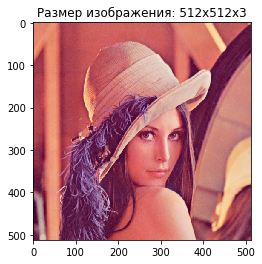

In [17]:
plt.imshow(img[...,::-1]) # b g r -> r g b
plt.title('Размер изображения: %dx%dx%d' % img.shape)

## Оператор Собеля

In [18]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [19]:
img.dtype

dtype('uint8')

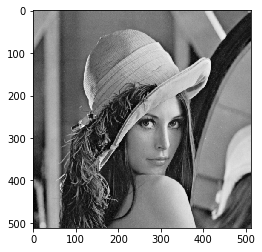

In [20]:
plt.imshow(img_gray, cmap='gray')

### Оператор собеля для вычисления X и Y составляющих градиента

In [21]:
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])
    
sobel_y = np.array([[-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]])

### Вычисляем градиенты по осям

In [22]:
grad_x = cv2.filter2D(img_gray, cv2.CV_32F, sobel_x)
grad_y = cv2.filter2D(img_gray, cv2.CV_32F, sobel_y)

In [25]:
grad_x # появились отрицательные значения, далее нормируем

array([[   0.,    0.,   -4., ...,  -64., -168.,    0.],
       [   0.,    0.,   -4., ...,  -64., -168.,    0.],
       [   0.,    0.,   -4., ...,  -64., -168.,    0.],
       ...,
       [   0.,   29.,   19., ...,    3.,  -14.,    0.],
       [   0.,   40.,   25., ...,   15.,    6.,    0.],
       [   0.,   44.,   28., ...,   20.,   16.,    0.]], dtype=float32)

In [26]:
grad_x_norm = np.abs(grad_x)/np.max(np.abs(grad_x))
grad_y_norm = np.abs(grad_y)/np.max(np.abs(grad_y))

In [27]:
grad_x_norm # нормировали от 0 до 1

array([[0.        , 0.        , 0.00581395, ..., 0.09302326, 0.24418604,
        0.        ],
       [0.        , 0.        , 0.00581395, ..., 0.09302326, 0.24418604,
        0.        ],
       [0.        , 0.        , 0.00581395, ..., 0.09302326, 0.24418604,
        0.        ],
       ...,
       [0.        , 0.04215116, 0.02761628, ..., 0.00436047, 0.02034884,
        0.        ],
       [0.        , 0.05813954, 0.03633721, ..., 0.02180232, 0.00872093,
        0.        ],
       [0.        , 0.06395349, 0.04069768, ..., 0.02906977, 0.02325581,
        0.        ]], dtype=float32)

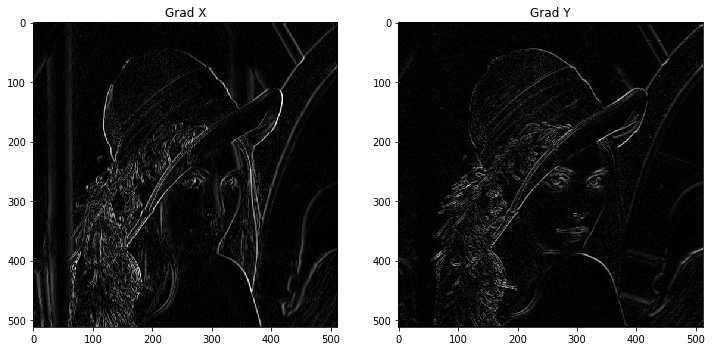

In [24]:
plt.figure(2, figsize=(12, 8))
plt.subplot(121)
plt.imshow(grad_x_norm, cmap='gray')
plt.title('Grad X')
plt.subplot(122)
plt.imshow(grad_y_norm, cmap='gray')
plt.title('Grad Y');

### Вычисляем суммарный градиент

In [28]:
grad = np.sqrt(grad_x ** 2 + grad_y ** 2)
theta = np.arctan2(grad_y, grad_x)

In [29]:
grad.shape

(512, 512)

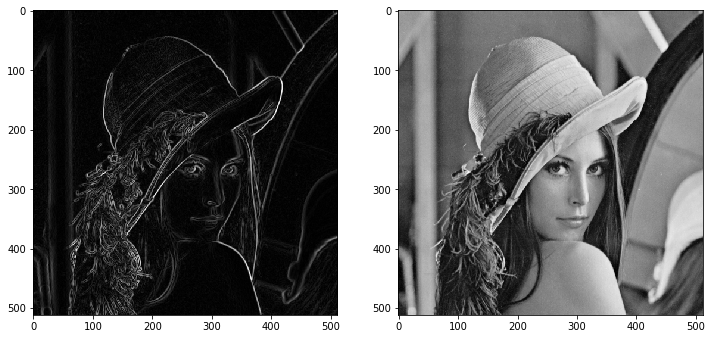

In [30]:
plt.figure(2, figsize=(12, 8))
plt.subplot(122)
plt.imshow(img_gray, cmap='gray')
plt.subplot(121)
plt.imshow(grad, cmap='gray')

## Функции создания ядер

Гауссиана:
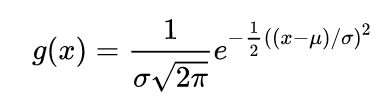

In [42]:
def gauss_kernel(ksize = 5, sigma = 2.5):
    """
    Возвращает гауссовское ядро размера ksize и дисперсией sigma
    ksize - размер ядра (int)
    sigma - дисперсия (ширина фильтра) (float)
    """
    
    # задаём координатную сетку
    ax = np.arange(-ksize // 2 + 1., ksize // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    
    # применяем функцию Гаусса
    e = np.float32((xx**2 + yy**2) / (2. * sigma**2))
    kernel = 1. / (sigma * np.sqrt(2. * np.pi)) * np.exp(-e)
    return kernel / np.sum(kernel) # нормируем (приводим сумму к 1)


def laplace_kernel(ksize = 5, sigma = 2.5):
    """
    Возвращает ядро Лапласа размера ksize и дисперсией sigma
    ksize - размер ядра (int)
    sigma - дисперсия (ширина фильтра) (float)
    """
    
    # задаём координатную сетку
    ax = np.arange(-ksize // 2 + 1., ksize // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    
    ## оператор Лапласа
    e = np.float32((xx**2 + yy**2) / (2. * sigma**2))
    kernel = 1. / (np.pi * sigma**4) * (1. - e) * np.exp(-e)
    return kernel / np.sum(kernel) # нормируем

kernels = {'gauss': gauss_kernel, 
           'laplace': laplace_kernel}

In [43]:
gauss_kernel(3)

array([[0.10518943, 0.11395035, 0.10518943],
       [0.11395035, 0.12344094, 0.11395035],
       [0.10518943, 0.11395035, 0.10518943]], dtype=float32)

In [44]:
gauss_kernel(5)

array([[0.02853721, 0.0362779 , 0.03929938, 0.0362779 , 0.02853721],
       [0.0362779 , 0.04611825, 0.0499593 , 0.04611825, 0.0362779 ],
       [0.03929938, 0.0499593 , 0.05412027, 0.0499593 , 0.03929938],
       [0.0362779 , 0.04611825, 0.0499593 , 0.04611825, 0.0362779 ],
       [0.02853721, 0.0362779 , 0.03929938, 0.0362779 , 0.02853721]],
      dtype=float32)

In [ ]:
###

In [33]:
ksize = 5
ax = np.arange(-ksize // 2 + 1., ksize // 2 + 1.)

In [34]:
ax

array([-2., -1.,  0.,  1.,  2.])

In [35]:
xx, yy = np.meshgrid(ax, ax)

In [36]:
xx

array([[-2., -1.,  0.,  1.,  2.],
       [-2., -1.,  0.,  1.,  2.],
       [-2., -1.,  0.,  1.,  2.],
       [-2., -1.,  0.,  1.,  2.],
       [-2., -1.,  0.,  1.,  2.]])

In [37]:
yy

array([[-2., -2., -2., -2., -2.],
       [-1., -1., -1., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 2.,  2.,  2.,  2.,  2.]])

In [38]:
print(xx[2,2])
print(yy[2][2])

0.0
0.0


In [39]:
sigma = 3
e = np.float32((xx**2 + yy**2) / (2. * sigma**2))
kernel = 1. / (sigma * np.sqrt(2. * np.pi)) * np.exp(-e)

In [40]:
kernel

array([[0.08526466, 0.10072829, 0.10648267, 0.10072829, 0.08526466],
       [0.10072829, 0.11899641, 0.12579441, 0.11899641, 0.10072829],
       [0.10648267, 0.12579441, 0.13298076, 0.12579441, 0.10648267],
       [0.10072829, 0.11899641, 0.12579441, 0.11899641, 0.10072829],
       [0.08526466, 0.10072829, 0.10648267, 0.10072829, 0.08526466]],
      dtype=float32)

In [41]:
kernel / np.sum(kernel) # получаем ядро у которого все элементы суммируются в 1

array([[0.0317564 , 0.03751576, 0.03965895, 0.03751576, 0.0317564 ],
       [0.03751576, 0.04431963, 0.04685151, 0.04431963, 0.03751576],
       [0.03965895, 0.04685151, 0.04952803, 0.04685151, 0.03965895],
       [0.03751576, 0.04431963, 0.04685151, 0.04431963, 0.03751576],
       [0.0317564 , 0.03751576, 0.03965895, 0.03751576, 0.0317564 ]],
      dtype=float32)

In [ ]:
###

## Визуализация ядер

\# pip install ipywidgets<br/>
\# jupyter nbextension enable --py widgetsnbextension

In [45]:
from mpl_toolkits.mplot3d import Axes3D

In [46]:
def show_kernel(kernel_type, ksize, sigma):
    kernel = kernels[kernel_type](ksize, sigma)
    r = np.arange(-ksize // 2 + 1., ksize // 2 + 1.)
    xx, yy = np.meshgrid(r, r)
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, kernel, 
                    cmap=plt.cm.coolwarm,
                    linewidth=0, antialiased=True)
    plt.title('%s ksize=%s sigma=%.3f' % (kernel_type, ksize, sigma))
    return plt.show()

In [47]:
from ipywidgets import interact

In [48]:
interact(show_kernel, 
         kernel_type = kernels.keys(),
         ksize = (1, 20, 1),
         sigma = (1e-3, 10, 0.1));

interactive(children=(Dropdown(description='kernel_type', options=('gauss', 'laplace'), value='gauss'), IntSli…

In [ ]:
# show_kernel('gauss',5 , 3)

## Фильтрация изображения

In [49]:
kernels

{'gauss': <function __main__.gauss_kernel(ksize=5, sigma=2.5)>,
 'laplace': <function __main__.laplace_kernel(ksize=5, sigma=2.5)>}

In [72]:
kernel = kernels['gauss'](3, 1)

In [73]:
kernel

array([[0.07511361, 0.12384141, 0.07511361],
       [0.12384141, 0.20417997, 0.12384141],
       [0.07511361, 0.12384141, 0.07511361]], dtype=float32)

In [74]:
img_filtered = cv2.filter2D(img, cv2.CV_32F, kernel)

In [75]:
(img_filtered>0).all() # все значения положительные

True

In [76]:
abs_img_filtered = np.abs(img_filtered)

In [77]:
# нормировка
channel_max = abs_img_filtered.max(axis=(0, 1))
norm_img_filtered = abs_img_filtered / channel_max

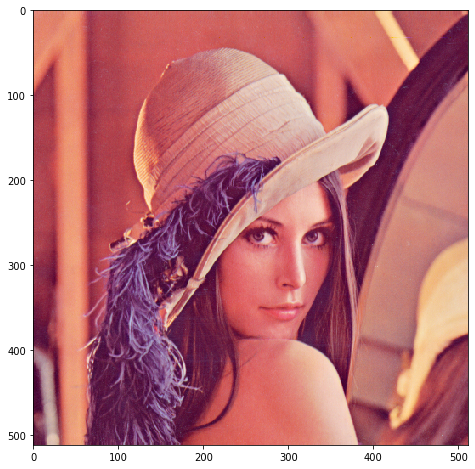

In [78]:
plt.figure(1, figsize=(8, 8))
plt.imshow(img[..., ::-1])

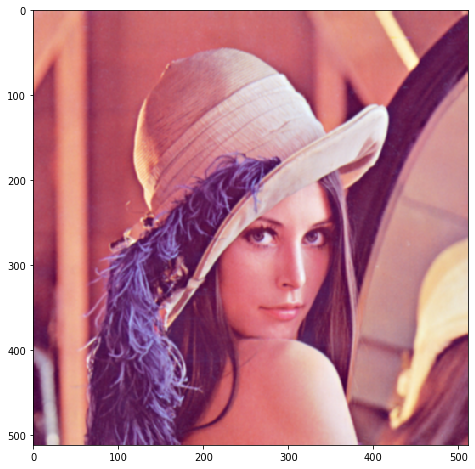

In [79]:
plt.figure(1, figsize=(8, 8))
plt.imshow(norm_img_filtered[..., ::-1])

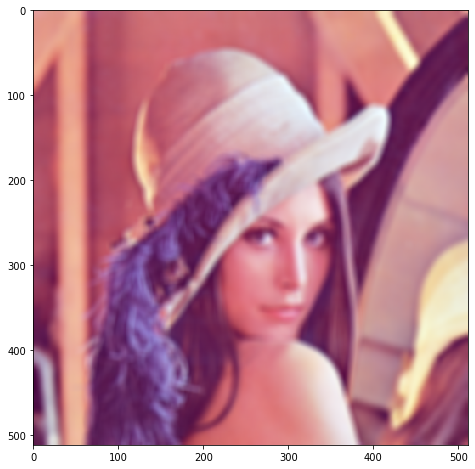

In [71]:
kernel = kernels['gauss'](10, 5)
img_filtered = cv2.filter2D(img, cv2.CV_32F, kernel)
abs_img_filtered = np.abs(img_filtered)
# нормировка
channel_max = abs_img_filtered.max(axis=(0, 1))
norm_img_filtered = abs_img_filtered / channel_max

plt.figure(1, figsize=(8, 8))
plt.imshow(norm_img_filtered[..., ::-1])

### Функция для отображения картинки в зависимости от ядра

In [80]:
def filter_img(kernel_type, ksize = 5, sigma = 2.5):
    kernel = kernels[kernel_type](ksize, sigma)
    result = cv2.filter2D(img, cv2.CV_32F, kernel)
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    img_abs = np.abs(result)
    img_norm = img_abs / np.max(img_abs, axis=(0, 1))
    ax.imshow(img_norm[...,::-1])
    plt.title('%s ksize=%s sigma=%.3f' % (kernel_type, ksize, sigma))
    return plt.show()

In [81]:
interact(filter_img, 
         kernel_type = kernels.keys(),
         ksize = (1, 20, 1),
         sigma = (1e-3, 10, 0.1));

interactive(children=(Dropdown(description='kernel_type', options=('gauss', 'laplace'), value='gauss'), IntSli…

In [84]:
def print_line(size):
    my_line = 'hello world'
    return my_line[:size]

In [85]:
interact(print_line, size=(0, 11, 1))

interactive(children=(IntSlider(value=5, description='size', max=11), Output()), _dom_classes=('widget-interac…

<function __main__.print_line(size)>

In [86]:
def print_hello_world(size):
    print('hello world'[:size])

In [87]:
interact(print_hello_world, size=(0, 11, 1))

interactive(children=(IntSlider(value=5, description='size', max=11), Output()), _dom_classes=('widget-interac…

<function __main__.print_hello_world(size)>

## Задания

* Пользуясь примером, напишите и примените фильтр увеличения контрастности из лекции
* Придумайте свой филтьтр-матрицу (любого размера, не обязательно 3x3) и примените его к изображению (при необходимости, нормируйте)

In [4]:
mean_filter = np.ones(49) # ядро размера 7
mean_filter.reshape(7, 7)

array([[1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.]])

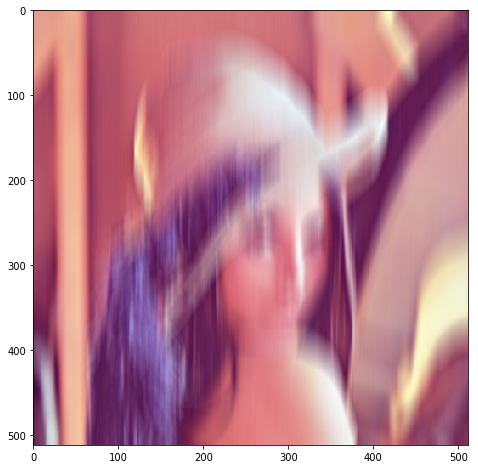

In [7]:
img_filtered = cv2.filter2D(img, cv2.CV_32F, mean_filter)
abs_img_filtered = np.abs(img_filtered)

# нормировка
channel_max = abs_img_filtered.max(axis=(0, 1))
norm_img_filtered = abs_img_filtered / channel_max
plt.figure(1, figsize=(8, 8))
plt.imshow(norm_img_filtered[..., ::-1])

In [ ]:
###

In [107]:
img = cv2.imread('lena.png')
kitten = cv2.imread('kitten-report.jpg')

In [108]:
images = {
    'lena': img,
    'kitten': kitten
}

In [109]:
def filter_img(kernel_type, image='lena', ksize = 5, sigma = 2.5):
    kernel = kernels[kernel_type](ksize, sigma)
    img = images[image]
    result = cv2.filter2D(img, cv2.CV_32F, kernel)
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    img_abs = np.abs(result)
    img_norm = img_abs / np.max(img_abs, axis=(0, 1))
    ax.imshow(img_norm[...,::-1])
    plt.title('%s ksize=%s sigma=%.3f' % (kernel_type, ksize, sigma))
    return plt.show()

In [115]:
interact(filter_img, 
         image = images.keys(),
         kernel_type = kernels.keys(),
         ksize = (1, 20, 1),
         sigma = (1e-3, 10, 0.1));

interactive(children=(Dropdown(description='kernel_type', options=('gauss', 'laplace'), value='gauss'), Dropdo…

In [116]:
###

In [120]:
my_kernel = np.array([[1,1,1],
                    [1,1,1],
                    [1,1,1]])

In [123]:
filtred_image = cv2.filter2D(img, cv2.CV_32F, my_kernel)
filtred_image = np.abs(filtred_image)/np.max(np.abs(filtred_image))

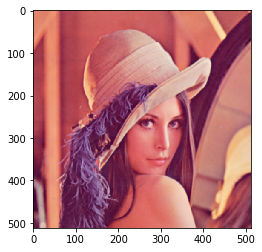

In [125]:
plt.imshow(filtred_image[..., ::-1])

In [ ]:
pass